In [37]:
!pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [39]:
#read data into a dataframe
df = pd.read_excel('../data/titanic3.xls')
df.drop(columns=['boat', 'body', 'parch', 'sibsp', 'ticket', 'fare'], inplace=True)
df['sex'] = df['sex'].apply(lambda x: 0 if str(x) == 'male' else 1 if str(x) == 'female' else x)
df['age'].fillna(df['age'].mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   int64  
 4   age        1309 non-null   float64
 5   cabin      295 non-null    object 
 6   embarked   1307 non-null   object 
 7   home.dest  745 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 81.9+ KB


In [40]:
def age_cat(age):
    if age < 18:
        return 'Child'
    elif 18 <= age < 65:  
        return 'Adult'
    elif age >= 65:  
        return 'Elder'
    else:
        return None

df['age category'] = df['age'].apply(lambda x: age_cat(x))
df

,pclass,survived,name,sex,age,cabin,embarked,home.dest,age category
0,1,1,"Allen, Miss. Elisabeth Walton",1,29.000000,B5,S,"St Louis, MO",Adult
1,1,1,"Allison, Master. Hudson Trevor",0,0.916700,C22 C26,S,"Montreal, PQ / Chesterville, ON",Child
2,1,0,"Allison, Miss. Helen Loraine",1,2.000000,C22 C26,S,"Montreal, PQ / Chesterville, ON",Child
3,1,0,"Allison, Mr. Hudson Joshua Creighton",0,30.000000,C22 C26,S,"Montreal, PQ / Chesterville, ON",Adult
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,25.000000,C22 C26,S,"Montreal, PQ / Chesterville, ON",Adult
...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",1,14.500000,NaN,C,NaN,Child
1305,3,0,"Zabour, Miss. Thamine",1,29.881135,NaN,C,NaN,Adult
1306,3,0,"Zakarian, Mr. Mapriededer",0,26.500000,NaN,C,NaN,Adult
1307,3,0,"Zakarian, Mr. Ortin",0,27.000000,NaN,C,NaN,Adult


In [41]:
encoded_df = pd.get_dummies(df['age category'])

# Merge the one-hot encoded columns back into the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop the original 'age category' column if needed
df = df.drop(columns=['age category'])
df = df.rename(columns={
    'age category_Adult': 'adult',
    'age category_Child': 'child',
    'age category_Elder': 'elder'
})

<Axes: >

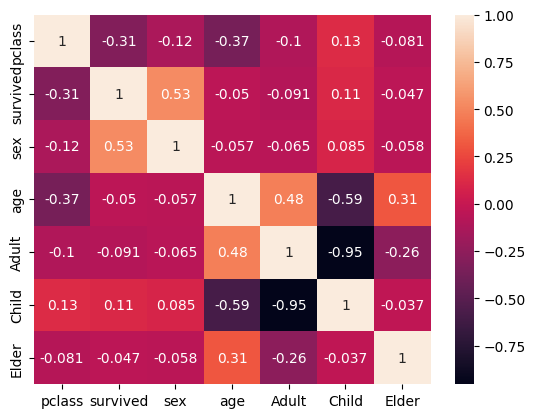

In [42]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

#### Testing models
Here I test three diffrent models: RandomForestClassefier, Xgboost and GradientBoostingClassifier. The results for the RandomForestClassefier were the best with Xgboost following close behind.

In [43]:
# Features
X = df[['age', 'pclass', 'sex']]
# Target variable (create and populate with real data)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X, y)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
feature_importances = clf.feature_importances_
print(feature_importances)
print(accuracy)

[0.39337672 0.17655169 0.43007159]
0.8129770992366412


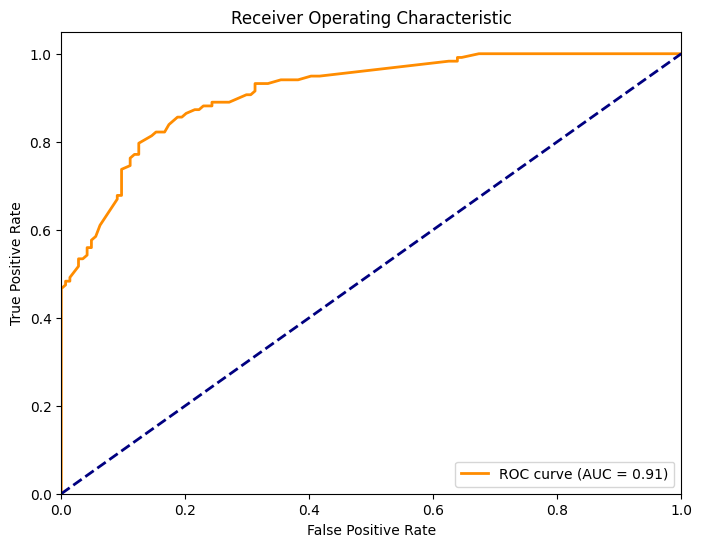

In [44]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probability of class 1 (positive class)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


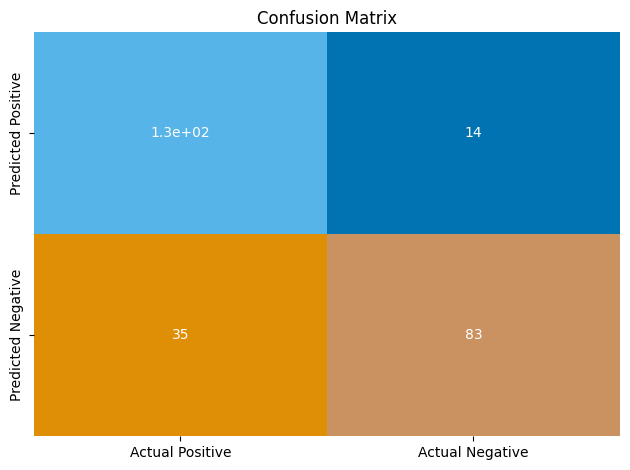

In [45]:
matrix = confusion_matrix(y_test, y_pred)
df_confusion = pd.DataFrame(matrix, index=['Predicted Positive','Predicted Negative'],columns=['Actual Positive','Actual Negative'])
# Print the confusion matrix
colormap = sns.color_palette("colorblind")
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [46]:
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
Sensitivity  = float(TP)/(TP+FN)*100
Specificity  = float(TN)/(TN+FP)*100
Precision = float(TP)/(TP+FP)*100
NPV = float(TN)/(TN+FN)*100
FPR = float(FP)/(FP+TN)*100
FNR = float(FN)/(TP+FN)*100
FDR = float(FP)/(TP+FP)*100
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 70.33898305084746%
Specificity or TNR: 90.27777777777779%
Precision: 85.56701030927834%
Negative Predictive Value: 78.78787878787878%
False Positive Rate: 9.722222222222223%
False Negative Rate: 29.66101694915254%
False Discovery Rate: 14.432989690721648%
Accuracy: 81.29770992366412%


In [47]:
# Features
X = df[['age', 'pclass', 'sex']]
# Target variable (create and populate with real data)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier()
model.fit(X, y)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
feature_importances = model.feature_importances_
print(feature_importances)
print(accuracy)

[0.03320751 0.16338143 0.803411  ]
0.8015267175572519


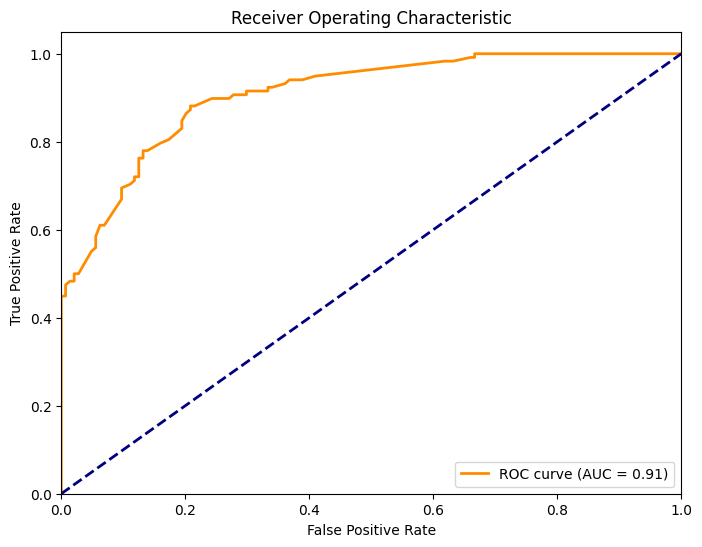

In [48]:
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (positive class)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


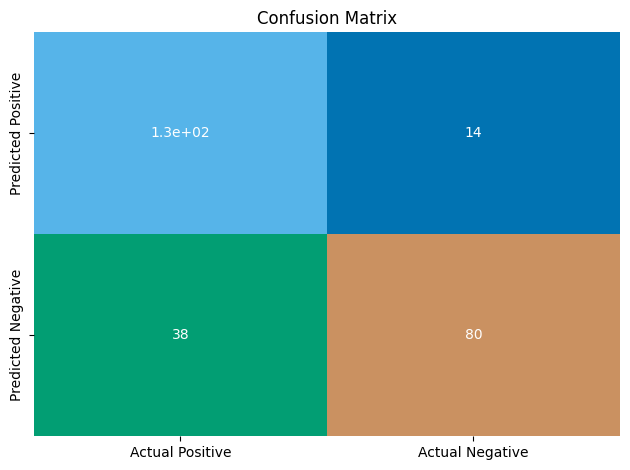

In [49]:
matrix = confusion_matrix(y_test, y_pred)
df_confusion = pd.DataFrame(matrix, index=['Predicted Positive','Predicted Negative'],columns=['Actual Positive','Actual Negative'])
# Print the confusion matrix
colormap = sns.color_palette("colorblind")
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [50]:
# Features
X = df[['age', 'pclass', 'sex']]
# Target variable (create and populate with real data)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

clf.fit(X, y)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
feature_importances = clf.feature_importances_
print(feature_importances)
print(accuracy)

[0.16762651 0.23735731 0.59501618]
0.7862595419847328


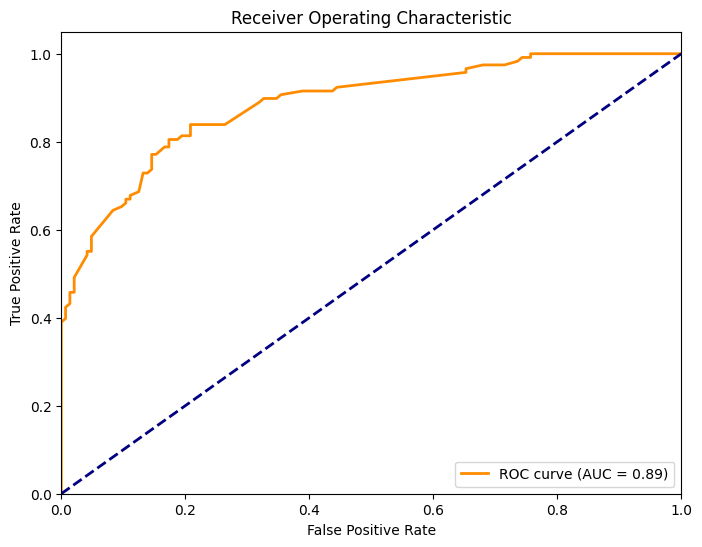

In [51]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probability of class 1 (positive class)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


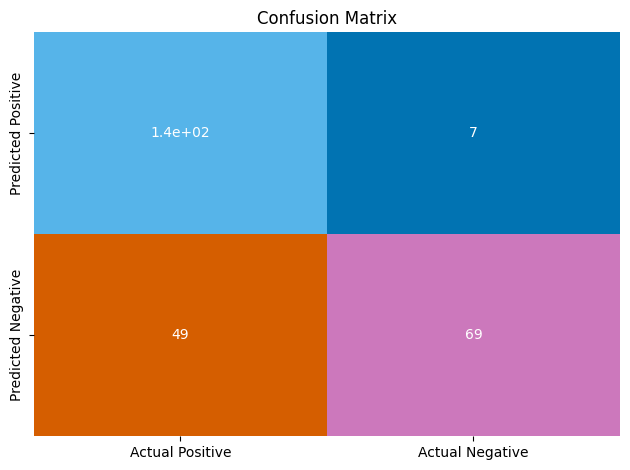

In [52]:
matrix = confusion_matrix(y_test, y_pred)
df_confusion = pd.DataFrame(matrix, index=['Predicted Positive','Predicted Negative'],columns=['Actual Positive','Actual Negative'])
# Print the confusion matrix
colormap = sns.color_palette("colorblind")
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()